### Distribution Visualization

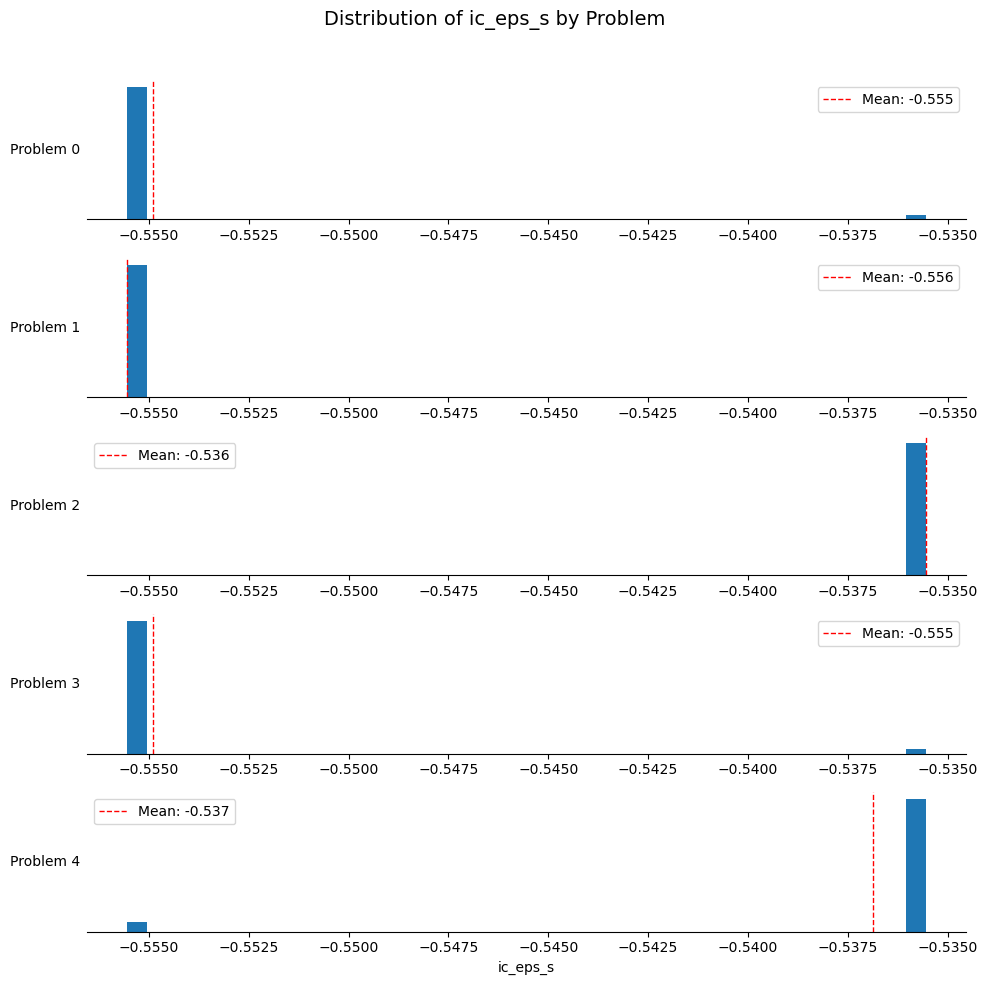

In [ ]:
import sqlite3, numpy as np, pandas as pd
import matplotlib.pyplot as plt

def plot_feature():
    # Connect to the SQLite database
    con = sqlite3.connect("data/landscape-analysis.db")
    query = "SELECT * FROM loss_surfaces WHERE ic_h_max IS NOT NULL AND ic_h_max != 'pending'"
    df = pd.read_sql_query(query, con)
    con.close()
    
    # Choose the feature to visualize
    feature = 'ic_eps_s'

    # Get unique problems
    problems = sorted(df['problem_id'].unique())

    # Prepare plot
    fig, axes = plt.subplots(len(problems), 1, figsize=(10, len(problems) * 2), sharex=False)
    
    # Handle case when there's only one problem
    if len(problems) == 1:
        axes = [axes]
    
    # Plot histograms per problem
    for i, problem in enumerate(problems):
        problem_data = df[df['problem_id'] == problem]
        
        # Calculate bins specific to this problem's data
        min_val = df[feature].min()
        max_val = df[feature].max()
        bins = np.linspace(min_val, max_val, 40)
        
        ax = axes[i]
        ax.hist(problem_data[feature], bins=bins, orientation='vertical')
        ax.set_yticks([])  # Hide y-axis ticks for compactness
        ax.set_ylabel(f"Problem {problem}", rotation=0, labelpad=30, va='center')
        
        # Add statistics to help compare
        mean_val = problem_data[feature].mean()
        ax.axvline(mean_val, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_val:.3f}')
        
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.legend()

    # Aesthetics
    axes[-1].set_xlabel(feature)
    plt.suptitle(f"Distribution of {feature} by Problem", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
plot_feature()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from src.LandscapeAnalysis import get_feature_names_by_prefixes

def plot_multiple_features():
    # Connect to the SQLite database
    con = sqlite3.connect("data/landscape-analysis.db")
    query = "SELECT * FROM loss_surfaces WHERE ic_h_max IS NOT NULL AND ic_h_max != 'pending'"
    df = pd.read_sql_query(query, con)
    con.close()
    
    # Define features to visualize
    features = get_feature_names_by_prefixes(['r10_ela_meta',])
    
    # Get unique problems
    problems = sorted(df['problem_id'].unique())

    # Create subplot grid
    fig, axes = plt.subplots(len(problems), len(features), 
                            figsize=(len(features) * 3, len(problems) * 1.5), 
                            sharex='col')
    
    # Handle case when there's only one problem
    if len(problems) == 1:
        axes = [axes]
        
    # Plot histograms for each problem and feature
    for i, problem in enumerate(problems):
        problem_data = df[df['problem_id'] == problem]
        for j, feature in enumerate(features):
            ax = axes[i][j]
            ax.hist(problem_data[feature].dropna(), 
                   bins=np.linspace(df[feature].min(), df[feature].max(), 40), 
                   orientation='vertical')
            ax.set_yticks([])  # Hide y-axis ticks
            
            # Set labels
            if j == 0:
                ax.set_ylabel(f"{problem}", rotation=0, labelpad=30, va='center')
            
            if i == len(problems) - 1:
                ax.set_xlabel(feature, fontsize=9)
                
            # Clean up appearance
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['left'].set_visible(False)

    # Add title and adjust layout
    plt.suptitle("Feature Distributions by Problem", fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_multiple_features()


Check the range of the parameter real quick

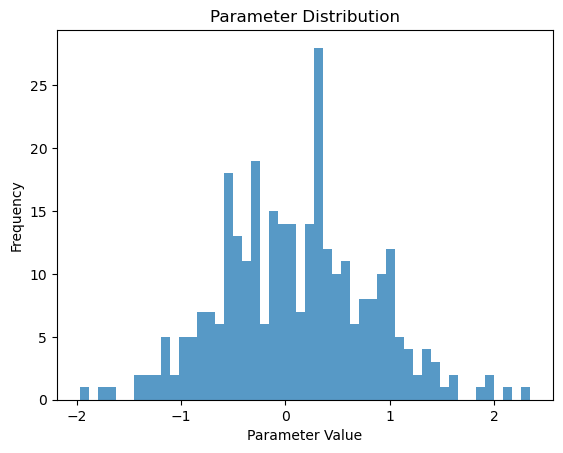

In [ ]:
import torch
from torch.nn.utils import parameters_to_vector
from matplotlib import pyplot as plt

def param_distribution():
    model = torch.load("fy601wtw-ed542e36.pth")
    vector = parameters_to_vector(model.values()).cpu().numpy()
    plt.hist(vector, bins=50, alpha=0.75)
    plt.title("Parameter Distribution")
    plt.xlabel("Parameter Value")
    plt.ylabel("Frequency")
    plt.show()
param_distribution() 

## UMAP

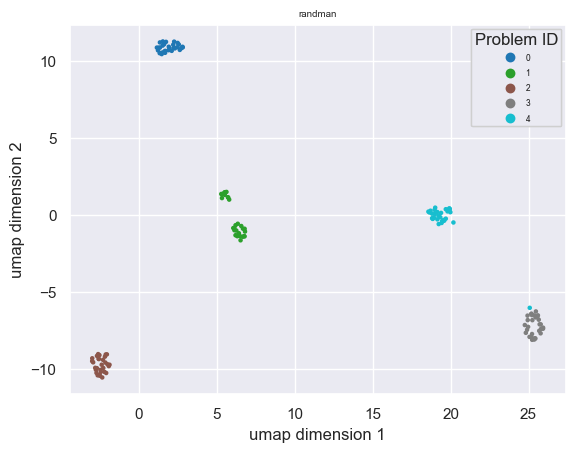

In [5]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()
import sqlite3, umap, numpy as np
from sklearn.decomposition import PCA
from src.LandscapeAnalysis import get_feature_names_by_prefixes, plot_pca_projection_matrix

def plot_randman_umap(method='umap'):
    features = get_feature_names_by_prefixes(['ic', 'pca', 'r10_ela_meta',])
    cols = ['problem_id'] + features
    cols = ", ".join(cols)
    
    con = sqlite3.connect("data/landscape-analysis.db")
    df = pd.read_sql_query(f"""
                           SELECT {cols} 
                           FROM loss_surfaces
                           WHERE problem_type = 'nn'                           
                           """, con)
    con.close()
    
    df= df.dropna()
    scaled = StandardScaler().fit_transform(df[features].values)
    
    if method == 'umap':
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(scaled)
    elif method == 'pca':
        reducer = PCA(n_components=5)
        embedding = reducer.fit_transform(scaled)
        
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], s=5, 
                          c=df['problem_id'], cmap='tab10')
    legend1 = plt.legend(*scatter.legend_elements(), title="Problem ID", fontsize=6)
    plt.gca().add_artist(legend1)

    plt.title('randman', fontsize=7)
    plt.xlabel(f'{method} dimension 1')
    plt.ylabel(f'{method} dimension 2')
    plt.show()
    if method == 'pca':
        # Plot variance explained
        explained_variance = reducer.explained_variance_ratio_
        cumulative_variance = explained_variance.cumsum()
        
        # Plot cumulative and individual variance explained
        plt.figure(figsize=(8, 5))
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual Variance')
        plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='red')
        plt.title("Variance Explained by PCA Components")
        plt.xlabel("Number of PCA Components")
        plt.ylabel("Variance Explained Ratio")
        plt.xticks(range(1, len(cumulative_variance) + 1))
        plt.legend()
        plt.grid()
        plt.show()
        
        # Use the plot_pca_projection_matrix function to plot the PCA projection matrix
        plot_pca_projection_matrix(reducer, df[features], top_n=20, n_components=3)
    
plot_randman_umap('umap')

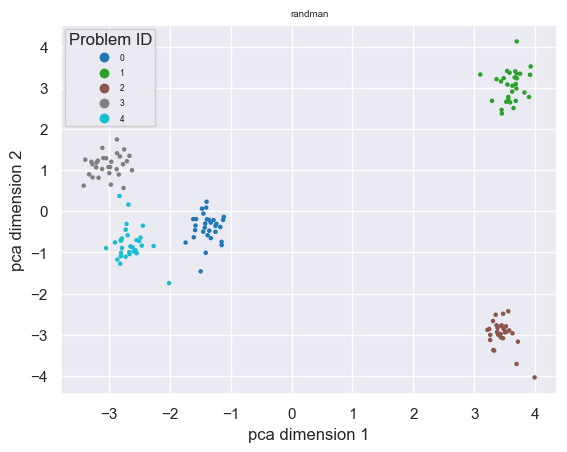

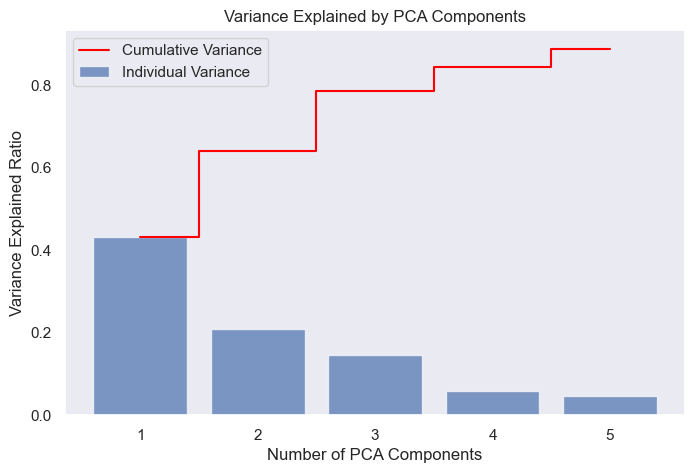

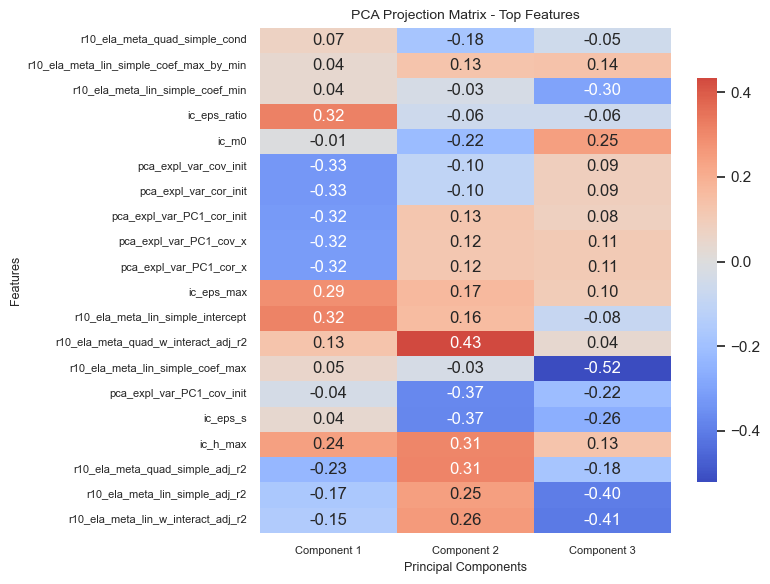

In [6]:
plot_randman_umap('pca')

TODO: 
* look at PCA to see which feature contribute (also for bbob problems)
* what does five ic featuers mean
* increase parameter ranges to see if PCA spread
    - color by different types of parameters


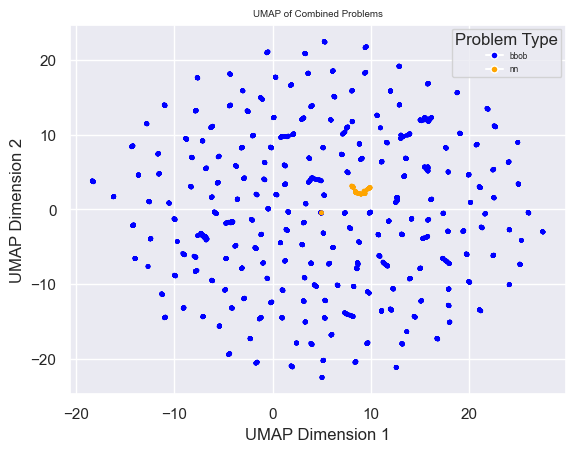

In [5]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_theme()
import sqlite3, umap
import pandas as pd
from src.LandscapeAnalysis.Analysis import get_feature_names_by_prefixes
from sklearn.decomposition import PCA


def plot_nn_and_bbob(method = 'umap'):
    con = sqlite3.connect("data/landscape-analysis.db")
    features = get_feature_names_by_prefixes(['ic', 'pca', 'r10_ela_meta',])
    cols = ['problem_id'] + features
    cols = ", ".join(cols)
    
    df_bbob = pd.read_sql_query(f"""
                           SELECT {cols} 
                           FROM loss_surfaces
                           WHERE problem_type = 'bbob'
                           """, con)
    df_nn = pd.read_sql_query(f"""
                           SELECT {cols} 
                           FROM loss_surfaces
                           WHERE problem_type = 'nn'
                           """, con)
    con.close()
    
    df_bbob= df_bbob.dropna()
    df_nn = df_nn.dropna()
    # Combine the dataframes and add a column to indicate the problem type
    df_bbob['problem_type'] = 'bbob'
    df_nn['problem_type'] = 'nn'
    df_combined = pd.concat([df_bbob, df_nn], ignore_index=True)
    
    # Scale the features
    scaled = StandardScaler().fit_transform(df_combined[features].values)
    
    if method == 'umap':
        # Apply UMAP
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(scaled)
    elif method == 'pca':
        pca = PCA(n_components=2)
        embedding = pca.fit_transform(scaled)
    
    # Map problem types to colors
    color_map = {'bbob': 'blue', 'nn': 'orange'}
    colors = df_combined['problem_type'].map(color_map)
    
    # Plot the UMAP embedding
    scatter = plt.scatter(embedding[:, 0], embedding[:, 1], s=5, c=colors)
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=key, markersize=5, markerfacecolor=color) 
                       for key, color in color_map.items()]
    plt.legend(handles=legend_elements, title="Problem Type", fontsize=6)
    
    plt.title('UMAP of Combined Problems', fontsize=7)
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.show()
    
plot_nn_and_bbob('umap')

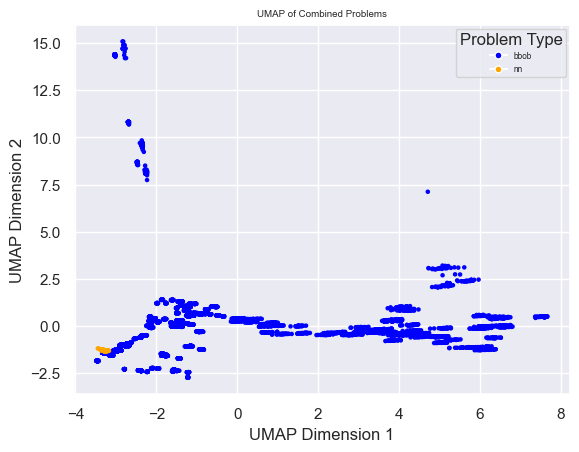

In [6]:
plot_nn_and_bbob('pca')

## Understanding BBOB features

### Are they dimensionality-invariant?

I want to know as the dimension of the BBOB increase, what features stay the same? 

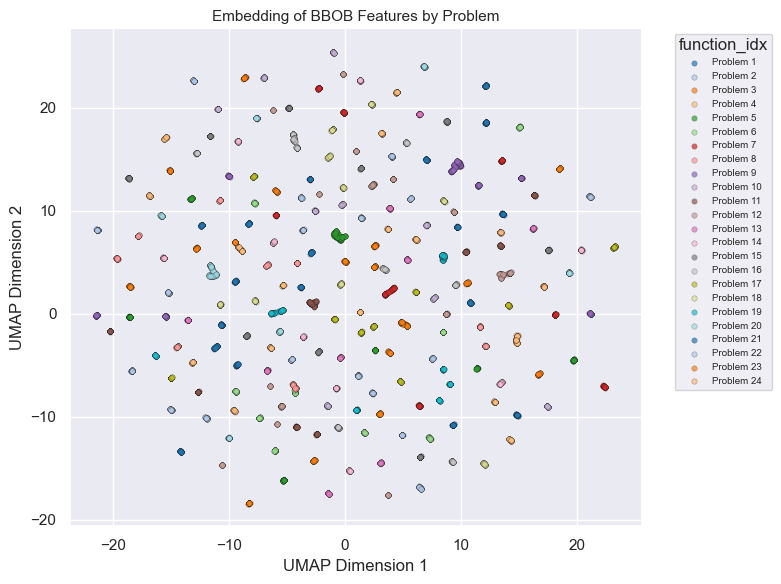

In [12]:
import pandas as pd
import sqlite3, umap
import pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.decomposition import PCA
from src.LandscapeAnalysis import get_feature_names_by_prefixes, plot_pca_projection_matrix

def plot_bbob_by_problems(method = 'umap'):
    feature_names = get_feature_names_by_prefixes(['ic', 'pca', 'r10_ela_meta'])
    cols = ['function_idx', 'dim'] + feature_names
    cols = ", ".join(cols)
    
    # Connect to SQLite
    con = sqlite3.connect("data/landscape-analysis.db")    
    df = pd.read_sql(f"""
        SELECT {cols}
        FROM loss_surfaces
        JOIN bbob_problems ON loss_surfaces.problem_id = bbob_problems.id
        WHERE problem_type = 'bbob'
    """, con)
    con.close()
    
    df_features = df[feature_names]
    df_features = df_features.dropna(axis='columns')
    
    # dim reduction
    scaled = StandardScaler().fit_transform(df_features.values)
    
    if method == 'umap':
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(scaled)
    elif method == 'pca':    
        pca = PCA(n_components=5)
        embedding = pca.fit_transform(scaled)
    
    # Plot embedding, color by problem_idx
    plt.figure(figsize=(8, 6))
    unique_problems = sorted(df['function_idx'].unique())
    palette = sns.color_palette("tab20", n_colors=len(unique_problems))
    problem_to_color = {problem: palette[i % len(palette)] for i, problem in enumerate(unique_problems)}
    for problem in unique_problems:
        mask = df['function_idx'] == problem
        plt.scatter(embedding[mask, 0], embedding[mask, 1], s=15,
                    c=[problem_to_color[problem]], label=f'Problem {problem}', alpha=0.7, edgecolor='k', linewidth=0.2)
    plt.legend(title='function_idx', fontsize=7, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title('Embedding of BBOB Features by Problem', fontsize=11)
    plt.xlabel(f'{method.upper()} Dimension 1')
    plt.ylabel(f'{method.upper()} Dimension 2')
    sns.despine()
    plt.tight_layout()
    plt.show()
    
    # additional plotting for PCA
    if method == 'pca':
        # Plot variance explained
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = explained_variance.cumsum()
        
        # Plot cumulative and individual variance explained
        plt.figure(figsize=(8, 5))
        plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.7, label='Individual Variance')
        plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative Variance', color='red')
        plt.title("Variance Explained by PCA Components")
        plt.xlabel("Number of PCA Components")
        plt.ylabel("Variance Explained Ratio")
        plt.xticks(range(1, len(cumulative_variance) + 1))
        plt.legend()
        plt.grid()
        plt.tight_layout()
        plt.show()
        
        # plot PCA projection matrix
        # PCA projection matrix


        # Call the function to plot PCA projection matrix
        plot_pca_projection_matrix(pca, df_features)
        

plot_bbob_by_problems('umap')

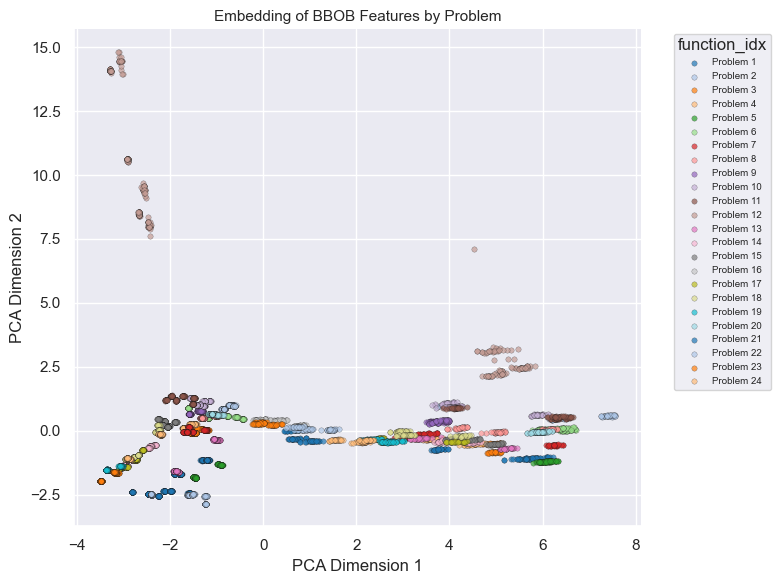

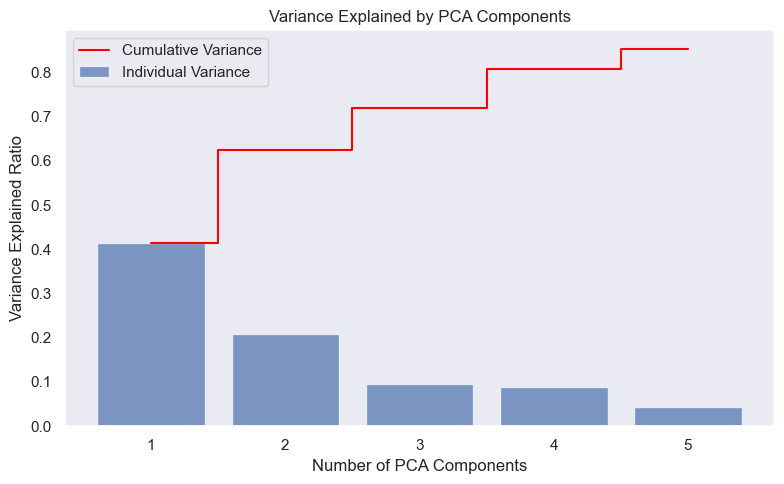

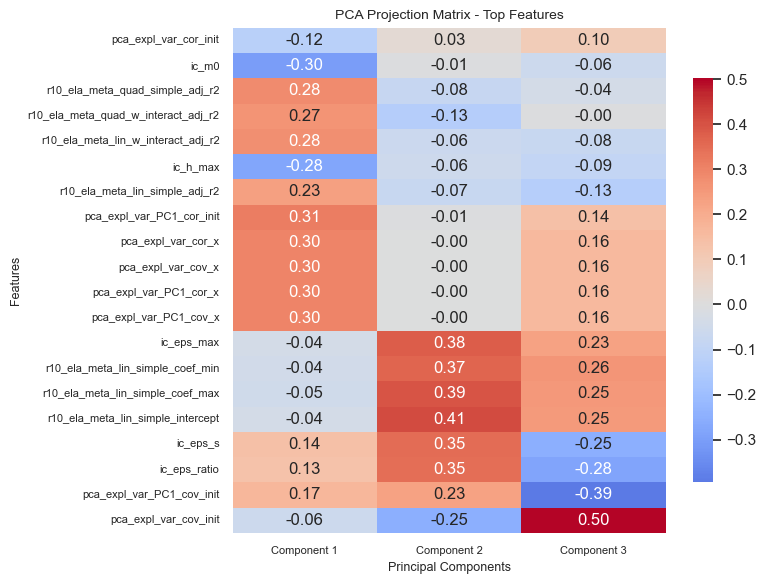

In [13]:
plot_bbob_by_problems('pca')

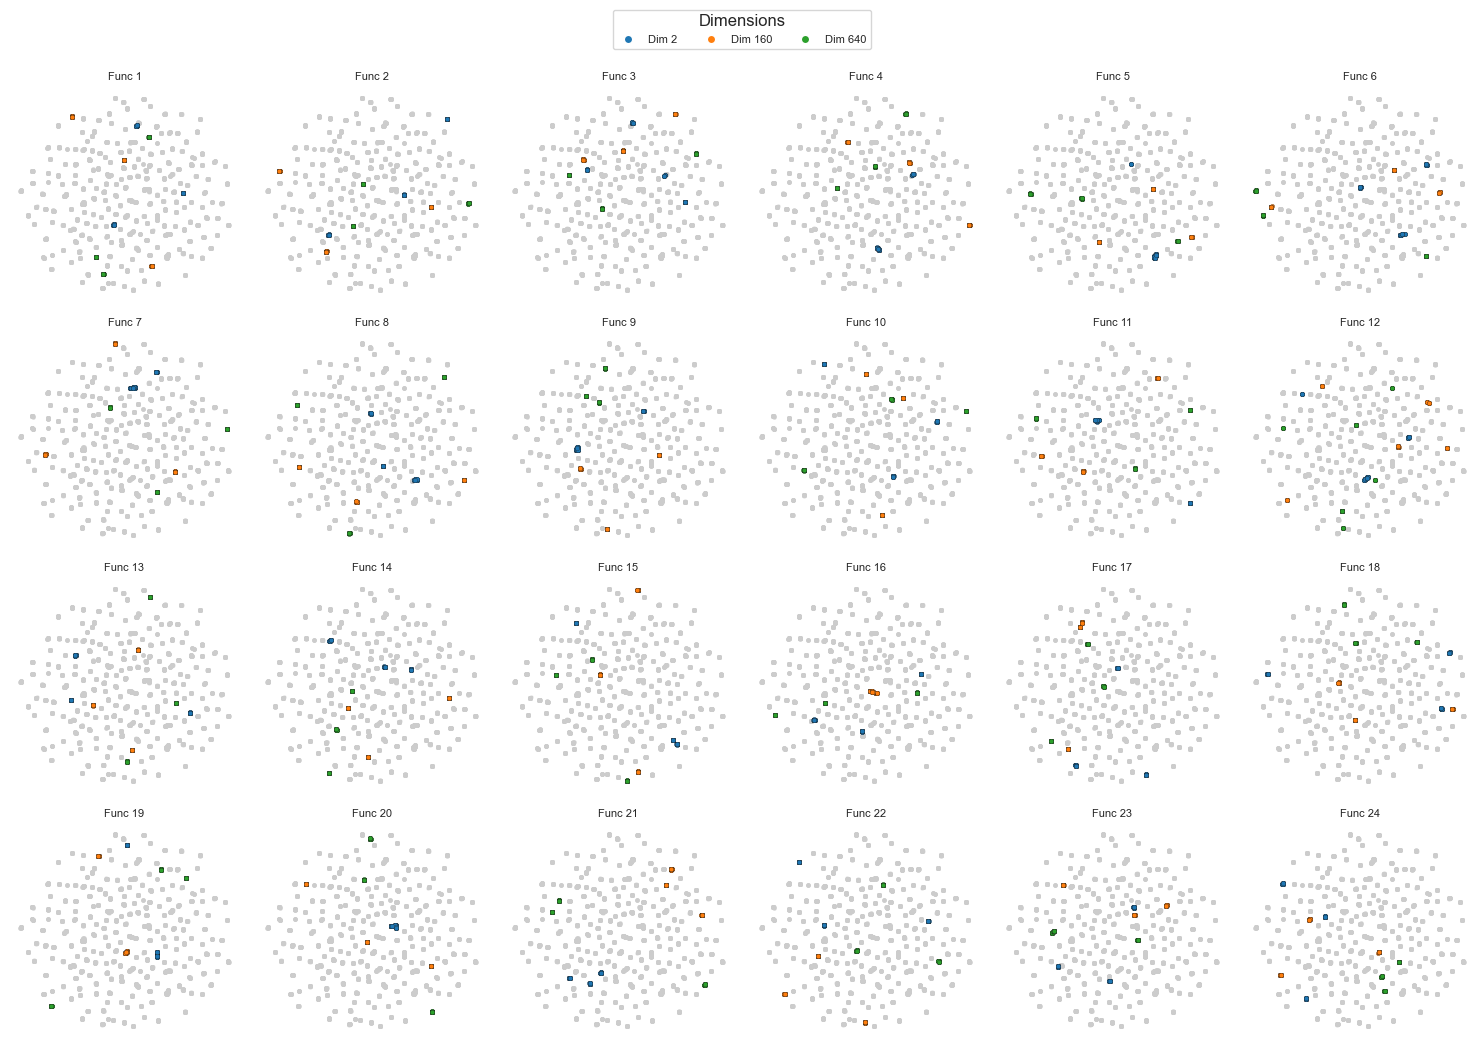

In [6]:
import sqlite3, umap
import pandas as pd, matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.decomposition import PCA


def check_dimensionality_invariance(method='umap', dims = None):
    feature_names = get_feature_names_by_prefixes(['ic', 'pca', 'r10_ela_meta'])
    cols = ['function_idx', 'dim'] + feature_names
    cols = ", ".join(cols)
    
    # Connect to SQLite
    con = sqlite3.connect("data/landscape-analysis.db")    
    query = f"""
        SELECT {cols}
        FROM loss_surfaces
        JOIN bbob_problems ON loss_surfaces.problem_id = bbob_problems.id
        WHERE problem_type = 'bbob'
    """
    if dims is not None:
        query += f" AND dim IN ({', '.join(map(str, dims))})"
    
    df = pd.read_sql(query, con)
    con.close()
    
    df_features = df[feature_names]
    df_features = df_features.dropna(axis='columns')
    
    # dim reduction
    scaled = StandardScaler().fit_transform(df_features.values)
    if method == 'umap':
        reducer = umap.UMAP()
        embedding = reducer.fit_transform(scaled)
    elif method == 'pca':
        pca = PCA(n_components=2)
        embedding = pca.fit_transform(scaled)
    
    # plotting with seaborn style
    sns.set_theme(style="whitegrid", font_scale=1)
    
    # Create a grid of subplots for all 24 functions
    fig, axes = plt.subplots(4, 6, figsize=(15, 10), sharex=True, sharey=True)
    axes = axes.flatten()
    
    # Prepare a color palette for dimensions
    unique_dims = sorted(df['dim'].unique())
    palette = sns.color_palette("tab10", n_colors=len(unique_dims))
    dim_to_color = {dim: palette[i % len(palette)] for i, dim in enumerate(unique_dims)}
    
    # Iterate over all function indices
    for func_idx in range(1, 25):
        ax = axes[func_idx - 1]
        mask = df['function_idx'] == func_idx
        
        # Plot gray points (other functions) first
        ax.scatter(embedding[~mask, 0], embedding[~mask, 1], s=5, c='#cccccc', alpha=0.5)
        
        # Then plot colored points (highlighted function) on top
        for dim in unique_dims:
            dim_mask = mask & (df['dim'] == dim)
            ax.scatter(embedding[dim_mask, 0], embedding[dim_mask, 1], s=10, 
                       c=[dim_to_color[dim]], edgecolor='k', linewidth=0.2)
        
        # Add a small title for each subplot
        ax.set_title(f'Func {func_idx}', fontsize=8)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    
    # Add a single legend for dimensions
    legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Dim {dim}', 
                              markerfacecolor=color, markersize=6) 
                       for dim, color in dim_to_color.items()]
    fig.legend(handles=legend_elements, title="Dimensions", loc='upper center', 
               bbox_to_anchor=(0.5, 1.05), ncol=len(unique_dims), fontsize=8)
    
    # Adjust layout for compactness
    plt.tight_layout()
    plt.show()
    
check_dimensionality_invariance(method='umap')

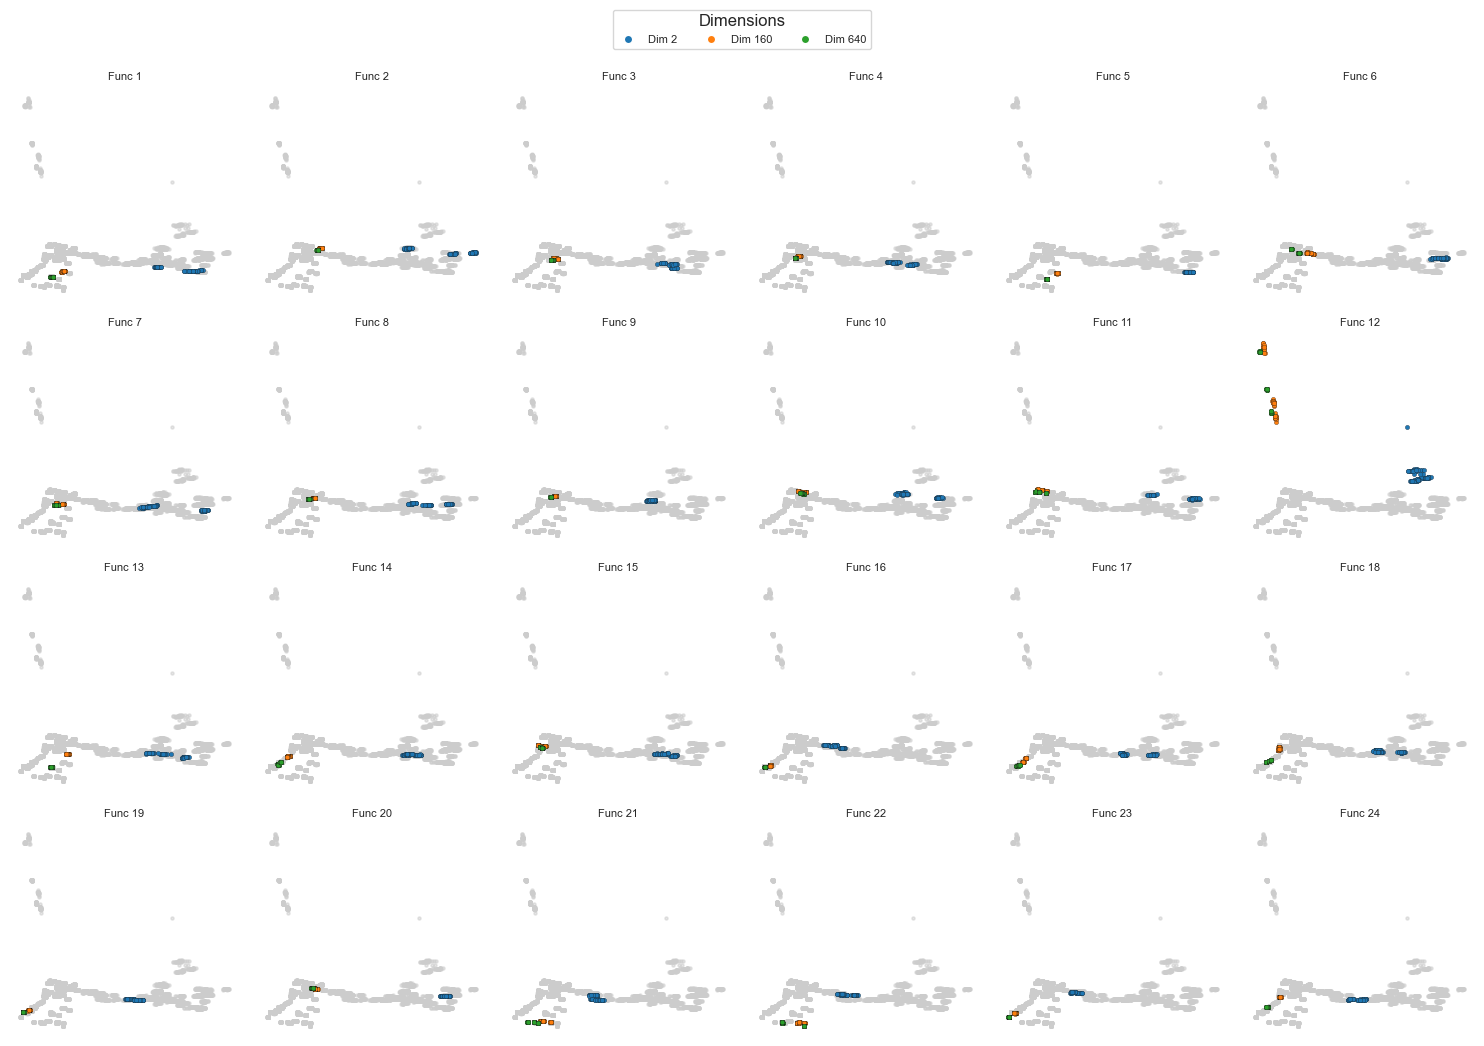

In [7]:
check_dimensionality_invariance(method='pca')

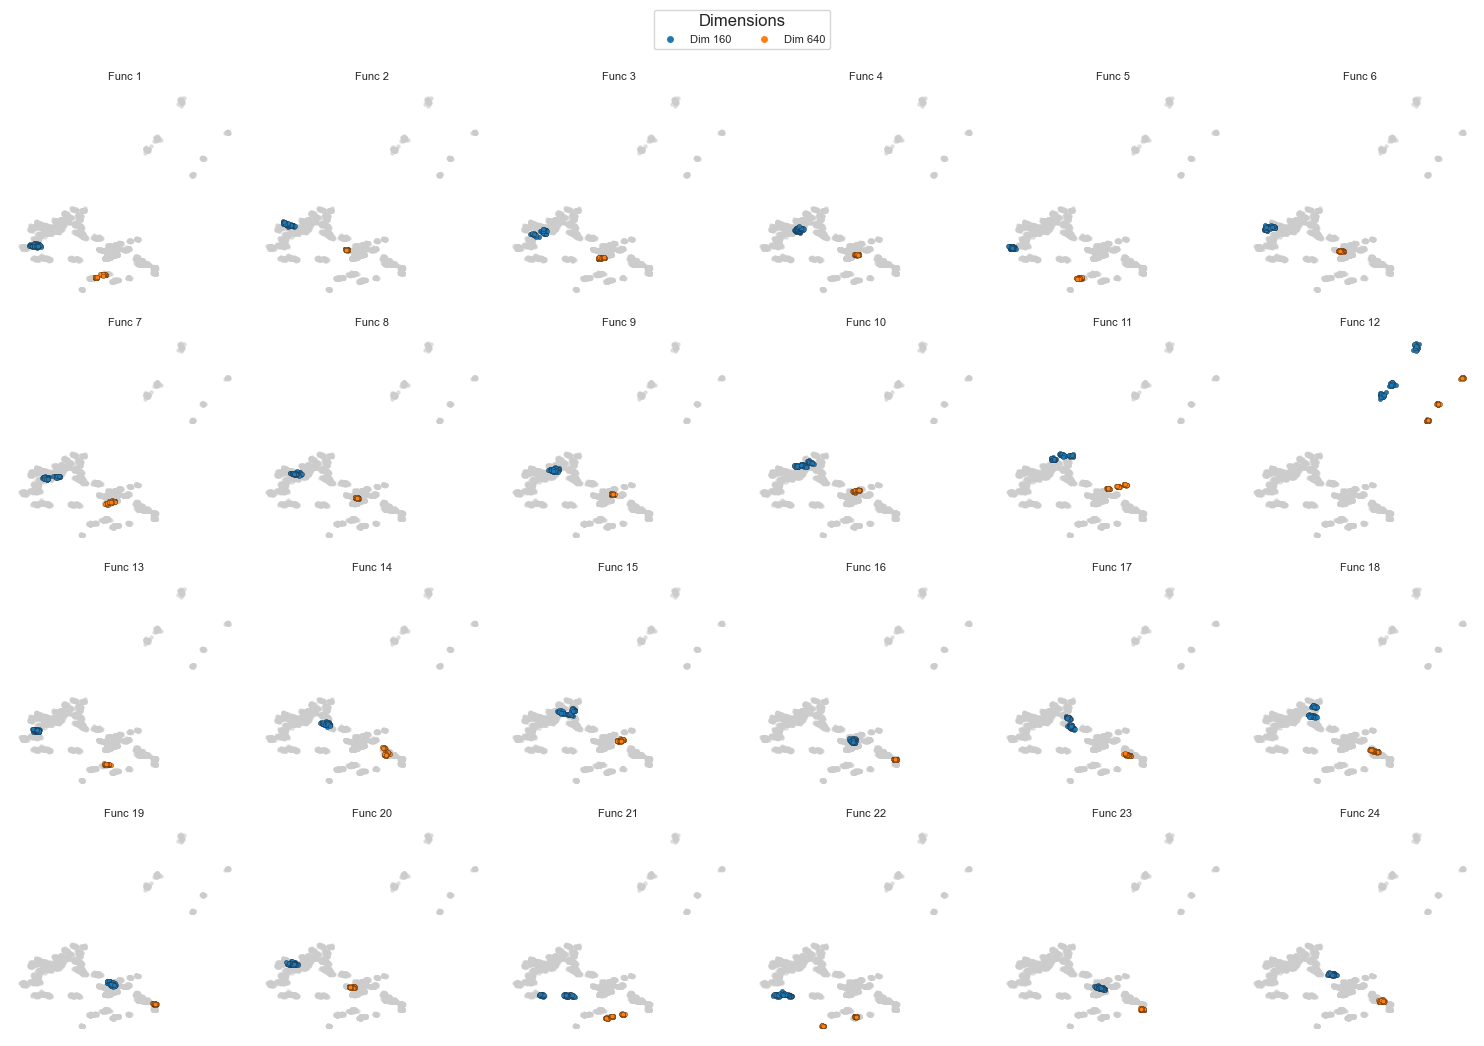

In [8]:
check_dimensionality_invariance(method='pca', dims=[160, 640])

### Effect of dimension

In [3]:
import plotly.express as px

from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3, umap
from sklearn.decomposition import PCA
from src.LandscapeAnalysis import get_feature_names_by_prefixes

def plot_by_dimensions(method ='umap', dims = None):
    feature_names = get_feature_names_by_prefixes(['ic', 'pca', 'r10_ela_meta'])
    bbob_cols = ['function_idx', 'dim'] + feature_names
    bbob_cols = ", ".join(bbob_cols)
    
    # Connect to SQLite
    con = sqlite3.connect("data/landscape-analysis.db")    
    
    # read bbob problems
    query = f"""
        SELECT {bbob_cols}
        FROM loss_surfaces
        JOIN bbob_problems ON loss_surfaces.problem_id = bbob_problems.id
        WHERE problem_type = 'bbob'
    """
    if dims is not None:
        query += f" AND dim IN ({', '.join(map(str, dims))})"
    
    bbob_df = pd.read_sql(query, con)
    
    
    # read nn problems
    nn_cols = ", ".join(feature_names)
    nn_df = pd.read_sql(f"""
        SELECT {nn_cols}
        FROM loss_surfaces
        WHERE problem_type = 'nn'
        """, con)
    con.close()
    
    # combine the dataframes and add a column to indicate the problem type
    bbob_df['problem_type'] = 'bbob'
    nn_df['problem_type'] = 'nn'
    combined_df = pd.concat([bbob_df, nn_df], ignore_index=True)
    df_features = combined_df[feature_names]
    df_features = df_features.dropna(axis='columns')
    
    # Dimensionality reduction
    scaled = StandardScaler().fit_transform(df_features.values)
    if method == 'umap':
        reducer = umap.UMAP(n_components=3)
        embedding = reducer.fit_transform(scaled)
    elif method == 'pca':
        pca = PCA(n_components=3)
        embedding = pca.fit_transform(scaled)
    
    # Plotting with plotly in 3D
    
    df_plot = pd.DataFrame(embedding, columns=[f'{method}_dim1', f'{method}_dim2', f'{method}_dim3'])
    df_plot['dim'] = bbob_df['dim'].astype(str)  # Convert 'dim' to string for categorical legend
    df_plot['problem_type'] = combined_df['problem_type']  # Add problem type to the plot data
    
    # Assign colors: one color for 'nn' and different colors for 'bbob' dimensions
    df_plot['color'] = df_plot.apply(
        lambda row: row['dim'] if row['problem_type'] == 'bbob' else 'nn', axis=1
    )
    
    fig = px.scatter_3d(
        df_plot, x=f'{method}_dim1', y=f'{method}_dim2', z=f'{method}_dim3',
        color='color', symbol='problem_type', title=f'{method.upper()} 3D Embedding Colored by Problem Type and Dimensions',
        labels={'color': 'Dimension/Problem Type', 'problem_type': 'Problem Type'}, opacity=0.7,
        color_discrete_sequence=px.colors.qualitative.Set1  # Use a categorical color palette
    )
    fig.update_traces(marker=dict(size=2))  # Make the dots smaller
    fig.update_layout(
        title=dict(font=dict(size=14), x=0.5, y=0.95),  # Center the title and adjust its position
        legend=dict(font=dict(size=10), itemsizing='constant', yanchor='top', y=0.9, xanchor='left', x=0.35),  # Adjust legend position
        margin=dict(l=10, r=10, t=30, b=10),  # Reduce margins for a tighter layout
        scene=dict(aspectmode='manual', aspectratio=dict(x=0.8, y=0.8, z=0.8))  # Make the figure smaller
    )
    fig.show()

plot_by_dimensions('umap')    

In [4]:
plot_by_dimensions('pca')

In [5]:
plot_by_dimensions('pca', dims=[160, 640])

* VISUALIZE feautres and problems as heat map

### correlation matrix

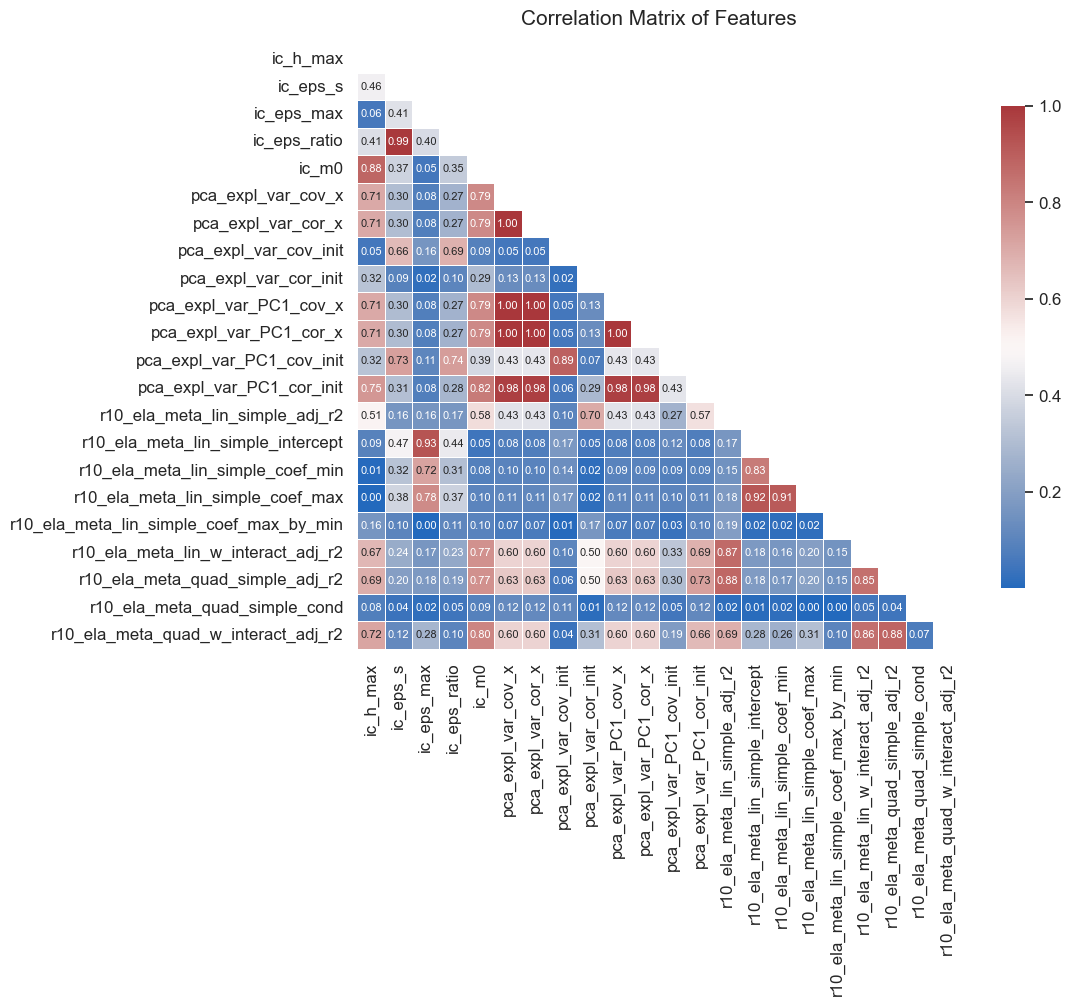

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlite3
import numpy as np

def plot_correlation():
    feature_names = get_feature_names_by_prefixes(['ic', 'pca', 'r10_ela_meta'])
    cols = ['function_idx', 'dim'] + feature_names
    cols = ", ".join(cols)
    
    # Connect to SQLite
    con = sqlite3.connect("data/landscape-analysis.db")    
    df = pd.read_sql(f"""
        SELECT {cols}
        FROM loss_surfaces
        JOIN bbob_problems ON loss_surfaces.problem_id = bbob_problems.id
        WHERE problem_type = 'bbob'
    """, con)
    con.close()
    
    df_features = df[feature_names]
    df_features = df_features.dropna(axis='columns')
    
    corr = df_features.corr().abs()
    plt.figure(figsize=(12, 10))
    sns.set_theme(style="white", font_scale=1.1)
    mask = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(
        corr, mask=mask, annot=True, fmt=".2f", cmap="vlag", 
        square=True, linewidths=0.5, cbar_kws={'shrink': 0.8}, 
        annot_kws={"size":8}
    )
    plt.title("Correlation Matrix of Features", fontsize=15, pad=15)
    plt.tight_layout()
    plt.show()
plot_correlation()

### Closest BBOB problems

In [7]:
from sklearn.metrics import pairwise_distances

def find_closest_bbob_problem(method='umap', dims=None):
    feature_names = get_feature_names_by_prefixes(['ic', 'pca', 'r10_ela_meta'])
    bbob_cols = ['function_idx', 'dim','problem_id'] + feature_names
    bbob_cols = ", ".join(bbob_cols)
    
    # Connect to SQLite
    con = sqlite3.connect("data/landscape-analysis.db")    
    
    # read bbob problems
    query = f"""
        SELECT {bbob_cols}
        FROM loss_surfaces
        JOIN bbob_problems ON loss_surfaces.problem_id = bbob_problems.id
        WHERE problem_type = 'bbob'
    """
    if dims is not None:
        query += f" AND dim IN ({', '.join(map(str, dims))})"
    
    bbob_df = pd.read_sql(query, con)
    
    # read nn problems
    nn_cols = ", ".join(['problem_id',] + feature_names)
    nn_df = pd.read_sql(f"""
        SELECT {nn_cols}
        FROM loss_surfaces
        WHERE problem_type = 'nn'
        """, con)
    con.close()
    
    # combine the dataframes and add a column to indicate the problem type
    bbob_df['problem_type'] = 'bbob'
    nn_df['problem_type'] = 'nn'
    combined_df = pd.concat([bbob_df, nn_df], ignore_index=True)
    df_features = combined_df[feature_names] # so problem_id and problem_types are gone
    df_features = df_features.dropna(axis='columns')
    
    # Dimensionality reduction
    scaled = StandardScaler().fit_transform(df_features.values)
    if method == 'umap':
        reducer = umap.UMAP(n_components=3)
        embedding = reducer.fit_transform(scaled)
    elif method == 'pca':
        pca = PCA(n_components=3)
        embedding = pca.fit_transform(scaled)
        
    # for each nn problem, find the 3 closest bbob problems
    # Separate embeddings for bbob and nn problems
    bbob_embedding = embedding[combined_df['problem_type'] == 'bbob']
    nn_embedding = embedding[combined_df['problem_type'] == 'nn']

    # Get corresponding problem IDs for bbob and nn problems
    bbob_info = bbob_df[['problem_id', 'function_idx', 'dim']].reset_index(drop=True)
    nn_info = nn_df[['problem_id']].reset_index(drop=True)

    # Compute pairwise distances between nn and bbob embeddings
    distances = pairwise_distances(nn_embedding, bbob_embedding)
    print(distances.shape)  # (num_nn_problems, num_bbob_problems)

    # Find the 3 closest bbob problems for each nn problem
    closest_indices = distances.argsort(axis=1)[:, :3]
    print(closest_indices.shape)  # (num_nn_problems, 3)

    # Display the closest bbob problems for each nn problem
    for i, nn_problem_id in enumerate(nn_info['problem_id']):
        print(f"NN Problem ID: {nn_problem_id}")
        for rank, idx in enumerate(closest_indices[i]):
            bbob_problem = bbob_info.iloc[idx]
            print(f"  Closest BBOB Problem {rank + 1}: Problem ID {bbob_problem['problem_id']}, "
                  f"Function Index {bbob_problem['function_idx']}, Dimension {bbob_problem['dim']}")
    
find_closest_bbob_problem()

(150, 6480)
(150, 3)
NN Problem ID: 0
  Closest BBOB Problem 1: Problem ID 110, Function Index 13, Dimension 2
  Closest BBOB Problem 2: Problem ID 110, Function Index 13, Dimension 2
  Closest BBOB Problem 3: Problem ID 110, Function Index 13, Dimension 2
NN Problem ID: 0
  Closest BBOB Problem 1: Problem ID 110, Function Index 13, Dimension 2
  Closest BBOB Problem 2: Problem ID 110, Function Index 13, Dimension 2
  Closest BBOB Problem 3: Problem ID 110, Function Index 13, Dimension 2
NN Problem ID: 0
  Closest BBOB Problem 1: Problem ID 110, Function Index 13, Dimension 2
  Closest BBOB Problem 2: Problem ID 110, Function Index 13, Dimension 2
  Closest BBOB Problem 3: Problem ID 110, Function Index 13, Dimension 2
NN Problem ID: 0
  Closest BBOB Problem 1: Problem ID 110, Function Index 13, Dimension 2
  Closest BBOB Problem 2: Problem ID 110, Function Index 13, Dimension 2
  Closest BBOB Problem 3: Problem ID 110, Function Index 13, Dimension 2
NN Problem ID: 0
  Closest BBOB Pro

* take account into same problems
* find existing SNN BBOs

In [8]:
def outer_fn():
    batch = 0
    def inner_fn():
        batch += 1
        print(f"Batch number: {batch}")
    return inner_fn

f = outer_fn()

In [9]:
f()

UnboundLocalError: cannot access local variable 'batch' where it is not associated with a value